# UMAPs Neurips samples, NK cells

In this notebook UMAPs are generated from latent space, CLR transformed protein counts and RNA expression to compare the clustering results. Leiden clusters are calculated for each object (latent, protein and RNA) and different NK cell markers are tested to identify CD56bright and CD56dim subsets. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot
from pySankey import sankey

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
#Neurips

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

adata

AnnData object with n_obs × n_vars = 80998 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [3]:
#Selecting only one sample
adata =adata[adata.obs['POOL'] == "s4d1"]

adata

View of AnnData object with n_obs × n_vars = 4885 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [4]:
#protein information

adata_prot=adata.obsm['protein_expression_clr_neurips']

In [5]:
#some proteins and genes have same names, here _prot added after protein names

adata_prot=adata_prot.rename(columns={'CD2': 'CD2_prot', 'CX3CR1': 'CX3CR1_prot', 'CD226':'CD226_prot', 'TIGIT':'TIGIT_prot', 'CD27':'CD27_prot', 'CD38': 'CD38_prot','CD34': 'CD34_prot', 'CD224': 'CD224_prot', 'CD7': 'CD7_prot', 'CD44': 'CD44_prot', 'CD34': 'CD34_prot','CD5': 'CD5_prot'})

In [6]:
#adding protein information to obs

a = adata.obs
b = adata_prot

df=pd.concat([a, b], axis=1)
adata.obs=df

adata

AnnData object with n_obs × n_vars = 4885 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16', 'CD25',

Here 3. different objects from the same adata object are created; latent, protein and RNA. UMAP neigbors are calculated differently for each object (either using latent space, CLR normalized protein, or RNA expression data and then visualized using UMAP projection. 

In [7]:
#Neurips, latent

adata_neurips_latent = adata.copy()

#Neurips, proteins

adata_neurips_prot = adata.copy()

#Neurips, RNA

adata_neurips_rna = adata.copy()

In [9]:
#RNA data is added to obs 

adata_neurips_rna.obsm['adata_x'] = adata_neurips_rna.to_df()


In [10]:
#Both NK cell types selected + one sample is selected

sample_latent = adata_neurips_latent[(adata_neurips_latent.obs['cell_type'] == "NK") | (adata_neurips_latent.obs['cell_type'] == "NK CD158e1+")]

In [11]:
#Both NK cell types selected  + one sample is selected

sample_prot = adata_neurips_prot[(adata_neurips_prot.obs['cell_type'] == "NK") | (adata_neurips_prot.obs['cell_type'] == "NK CD158e1+")]

In [12]:
#Both NK cell types selected  + one sample is selected

sample_rna = adata_neurips_rna[(adata_neurips_rna.obs['cell_type'] == "NK") | (adata_neurips_rna.obs['cell_type'] == "NK CD158e1+")]

In [13]:
adata_latent = sample_latent
adata_gex = sample_rna
adata_adt = sample_prot

# Marker testing

In [17]:
#Calculating neighbors for UMAPs

sc.pp.neighbors(adata_latent, use_rep="X_totalVI")    
sc.pp.neighbors(adata_adt, use_rep = 'protein_expression_clr_neurips') 
sc.pp.neighbors(adata_gex) 

sc.tl.umap(adata_latent)
sc.tl.umap(adata_adt)
sc.tl.umap(adata_gex)

Latent


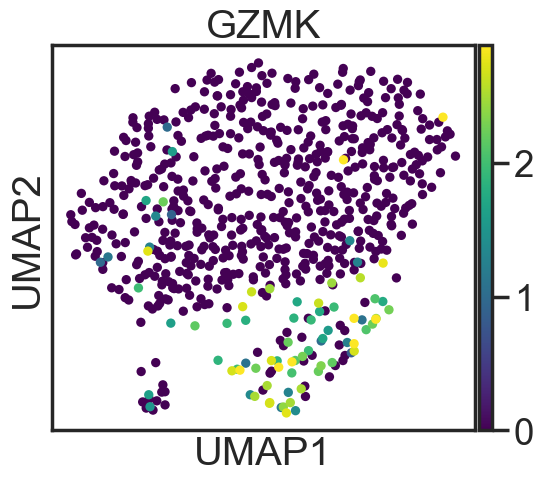

Protein


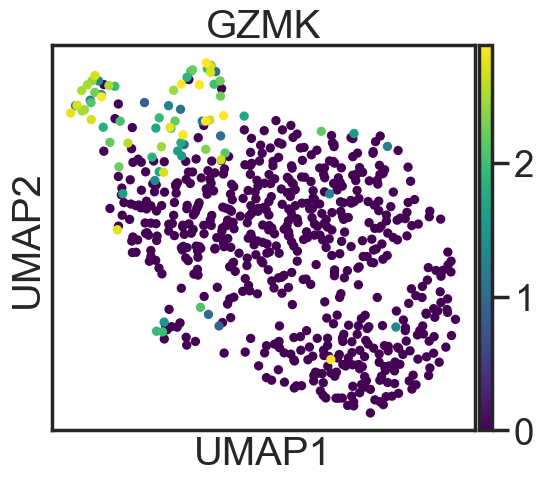

RNA


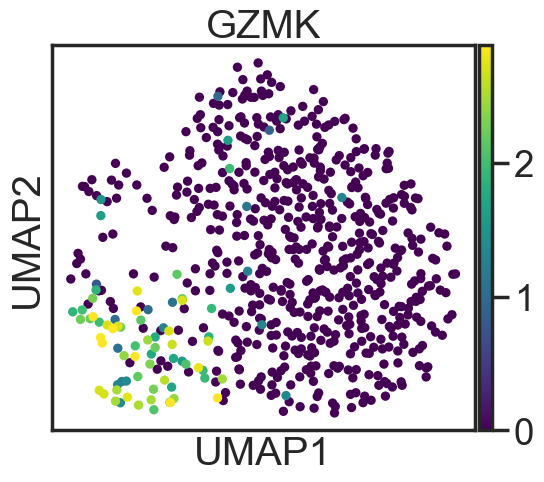

In [22]:
#Marker of immature cluster

sns.set(style='white', font_scale = 1.2, context='poster', rc={'figure.figsize':(6,5)})

print("Latent")
sc.pl.umap(adata_latent, color = ['GZMK'], vmax="p99", color_map = 'viridis', ncols = 3)
print("Protein")
sc.pl.umap(adata_adt, color = ['GZMK'], vmax="p99", color_map = 'viridis', ncols = 3)
print("RNA")
sc.pl.umap(adata_gex, color = ['GZMK'], vmax="p99", color_map = 'viridis', ncols = 3)




Latent


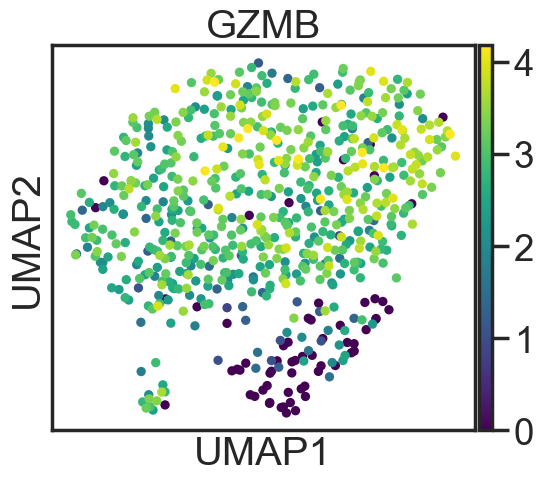

Protein


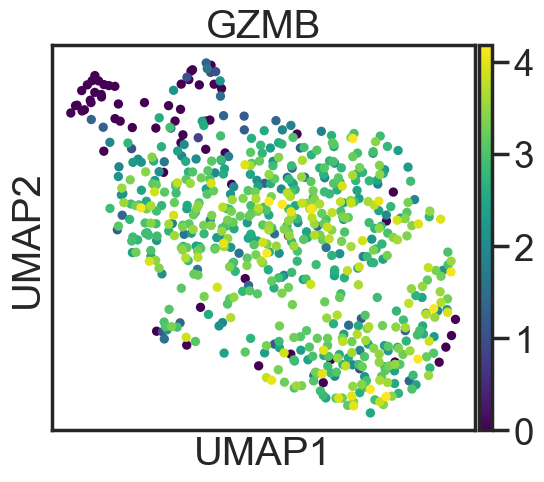

RNA


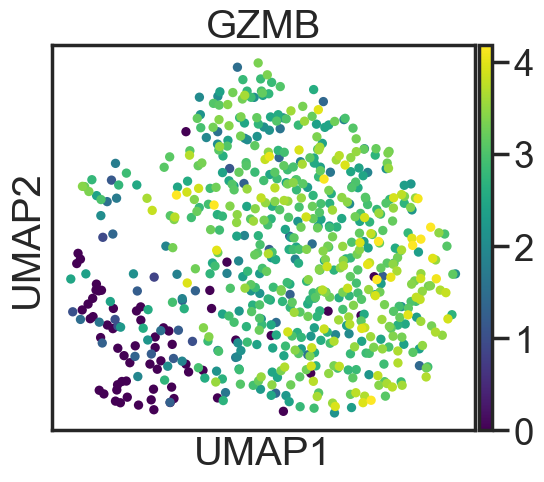

In [23]:
#Marker of mature NK cells

sns.set(style='white', font_scale = 1.2, context='poster', rc={'figure.figsize':(6,5)})

print("Latent")
sc.pl.umap(adata_latent, color = ['GZMB'], vmax="p99", color_map = 'viridis', ncols = 3)
print("Protein")
sc.pl.umap(adata_adt, color = ['GZMB'], vmax="p99", color_map = 'viridis', ncols = 3)
print("RNA")
sc.pl.umap(adata_gex, color = ['GZMB'], vmax="p99", color_map = 'viridis', ncols = 3)




Latent


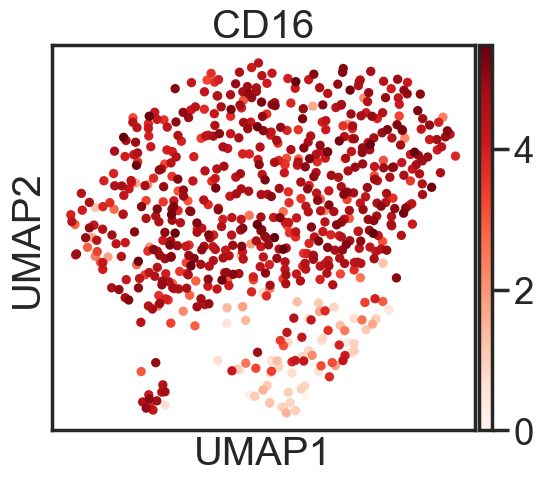

Protein


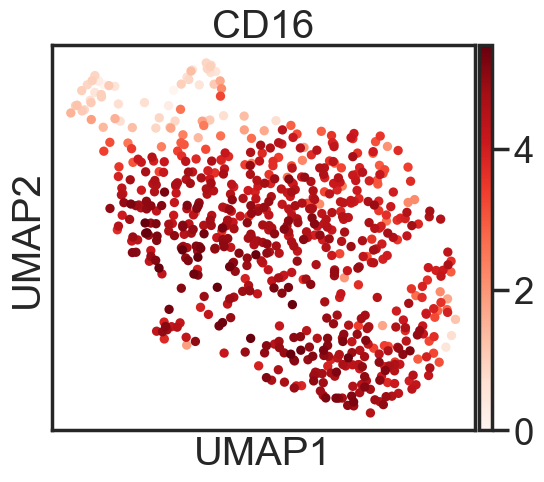

RNA


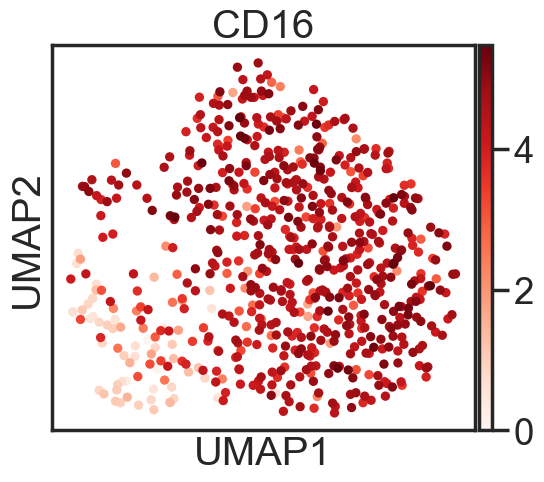

In [25]:
sns.set(style='white', font_scale = 1.2, context='poster', rc={'figure.figsize':(6,5)})

print("Latent")
sc.pl.umap(adata_latent, color = ['CD16'], vmax="p99", color_map = 'Reds', ncols = 3)
print("Protein")
sc.pl.umap(adata_adt, color = ['CD16'], vmax="p99", color_map = 'Reds', ncols = 3)
print("RNA")
sc.pl.umap(adata_gex, color = ['CD16'], vmax="p99", color_map = 'Reds', ncols = 3)

